In [125]:
import pandas as pd
from typing import Dict, Tuple, List, Any

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from architecture_new_new.deep_binary_classifier import DeepBinaryClassifier
from architecture_new_new.ripper_node_reduced import make_ripper_node_reduced

In [126]:
df = pd.read_csv("./data/10_bit_artificial/107.csv")
X = df.drop(columns="class").to_numpy(bool)
y = df["class"].to_numpy(bool)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (819, 10), X_test: (205, 10)
y_train: (819,), y_test: (205,)


In [127]:
config = dict(
    layer_node_counts=[8]*3 + [1], # 16 s good too
    layer_bit_counts=[4]*4,
    seed=42
)

net = DeepBinaryClassifier(**config, node_factory=make_ripper_node_reduced, jobs=8)
_ = net.fit(X_train, y_train)

pred_test = net.predict(X_test)
acc_before = accuracy_score(y_test, pred_test)
print(f"Accuracy (before pruning): {acc_before:.6f}")

Accuracy (before pruning): 0.848780


In [128]:
from typing import Dict, Any, List

def describe_architecture_names_full(net) -> Dict[str, Any]:
    if not getattr(net, "layers", None):
        raise RuntimeError("Network not fitted; no layers to describe.")
    if not getattr(net, "layer_feature_names", None):
        raise RuntimeError("Missing net.layer_feature_names")

    L = len(net.layers)

    # Layers by names (layer 0 are inputs)
    layers = [{'layer': l, 'nodes': list(net.layer_feature_names[l])} for l in range(L+1)]

    # Map name -> layer
    name_to_layer: Dict[str, int] = {
        nm: l for l in range(L+1) for nm in net.layer_feature_names[l]
    }

    # Connections by NAME -> feature_names actually used in the node
    connections: Dict[str, List[str]] = {}
    node_meta: Dict[str, Dict[str, Any]] = {}

    for l in range(1, L+1):
        curr_names = net.layer_feature_names[l]
        for j, node in enumerate(net.layers[l - 1]):
            node_name = curr_names[j]
            used_features = list(getattr(node, "feature_names", []))
            connections[node_name] = used_features

            meta = {
                'bits': len(used_features),
                'parents': used_features,
            }
            if hasattr(node, "get_expr"):
                try:
                    meta['rule'] = str(node.get_expr())
                except Exception:
                    meta['rule'] = None
            node_meta[node_name] = meta

    # Collect Used Inputs: all input names that appear in any connection
    used_inputs = sorted(
        {nm for feats in connections.values() for nm in feats if nm.startswith("L0N")}
    )

    return {
        'layers': layers,
        'connections': connections,     # node_name -> feature_names
        'node_meta': node_meta,
        'name_to_layer': name_to_layer,
        'L': L,
        'used_inputs': used_inputs,
    }

def print_architecture_names_full(desc: Dict[str, Any]) -> None:
    print("Used Inputs:", ", ".join(desc['used_inputs']))
    print("Layers & backlinks:")
    for layer in desc['layers'][1:]:
        l = layer['layer']
        print(f"  L{l}: {len(layer['nodes'])} node(s)")
        for n in layer['nodes']:
            parents = desc['connections'].get(n, [])
            print(f"    {n} - {parents}")



desc_all = describe_architecture_names_full(net)
print_architecture_names_full(desc_all)

Used Inputs: L0N0, L0N1, L0N2, L0N3, L0N4, L0N5, L0N6, L0N7, L0N8, L0N9
Layers & backlinks:
  L1: 8 node(s)
    L1N0 - ['L0N1', 'L0N9']
    L1N1 - ['L0N1', 'L0N4', 'L0N5', 'L0N8']
    L1N2 - ['L0N1', 'L0N6', 'L0N7', 'L0N8']
    L1N3 - ['L0N0', 'L0N2', 'L0N3', 'L0N7']
    L1N4 - ['L0N2', 'L0N6', 'L0N7', 'L0N9']
    L1N5 - ['L0N0', 'L0N2', 'L0N8']
    L1N6 - ['L0N1', 'L0N3', 'L0N4', 'L0N5']
    L1N7 - ['L0N1', 'L0N5', 'L0N6', 'L0N9']
  L2: 8 node(s)
    L2N0 - ['L1N0', 'L1N2']
    L2N1 - ['L1N1', 'L1N3', 'L1N5', 'L1N6']
    L2N2 - ['L1N0', 'L1N5']
    L2N3 - ['L1N1', 'L1N2', 'L1N5', 'L1N7']
    L2N4 - ['L1N0']
    L2N5 - ['L1N2', 'L1N3', 'L1N4', 'L1N7']
    L2N6 - ['L1N0', 'L1N1', 'L1N2', 'L1N3']
    L2N7 - ['L1N3', 'L1N5', 'L1N6', 'L1N7']
  L3: 8 node(s)
    L3N0 - ['L2N0', 'L2N2', 'L2N3', 'L2N7']
    L3N1 - ['L2N0', 'L2N2', 'L2N6']
    L3N2 - ['L2N2', 'L2N4', 'L2N6']
    L3N3 - ['L2N2', 'L2N3', 'L2N7']
    L3N4 - ['L2N2', 'L2N4', 'L2N6']
    L3N5 - ['L2N0', 'L2N4', 'L2N5', 'L2N7']
    

In [129]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

# --- Global font config: mathtext only (no TeX, no system serif lookup) ---
mpl.rcParams.update({
    "text.usetex": False,        # don't call external TeX
    "mathtext.fontset": "cm",    # Computer Modern for mathtext
    "axes.unicode_minus": False,
    "font.family": "DejaVu Sans",# safe default, no warnings
    "font.weight": "bold"        # make all fonts bold globally
})

def _contrast_color(face_rgba):
    r, g, b, _ = face_rgba
    L = 0.2126*r + 0.7152*g + 0.0722*b
    return 'black' if L > 0.5 else 'white'

def plot_architecture_networkx(
        desc,
        use_used_inputs: bool = True,
        x_gap: float = 3.2,
        y_gap: float = 1.35,
        node_size_pt: float = 34.0,
        edge_width: float = 1.6,
        edge_color: str | None = None,
        figsize=(18, 9),
        aspect: str = 'equal',
):
    layers = desc['layers']
    connections = desc['connections']

    # take nodes layer by layer
    layer_nodes = [list(layer['nodes']) for layer in layers]

    # Labels: N_i
    labels = {nm: rf"$N_{{{i}}}$" for l, nms in enumerate(layer_nodes) for i, nm in enumerate(nms)}

    # Layer titles: INPUT / OUTPUT / hidden L_k
    layer_titles = []
    for l in range(len(layer_nodes)):
        if l == 0:
            layer_titles.append(rf"$INPUT$")
        elif l == len(layer_nodes) - 1:
            layer_titles.append(rf"$OUTPUT$")
        else:
            layer_titles.append(rf"$L_{{{l}}}$")

    # Positions (flipped vertically: 0 at top, highest at bottom)
    pos = {}
    for l, nms in enumerate(layer_nodes):
        k = len(nms)
        if k == 0:
            continue
        ys = (np.arange(k)[::-1] - (k - 1) / 2.0) * y_gap  # flipped order
        xs = np.full(k, l * x_gap)
        for i, nm in enumerate(nms):
            pos[nm] = (xs[i], ys[i])

    # Graph
    G = nx.DiGraph()
    G.add_nodes_from(pos)
    for child, parents in connections.items():
        for p in parents:
            if p in pos and child in pos:
                G.add_edge(p, child)

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    face = ax.get_facecolor()
    ec = edge_color or _contrast_color(face)

    nx.draw_networkx_edges(G, pos, width=edge_width, edge_color=ec, arrows=False, ax=ax, alpha=0.95)
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_size_pt**2,
        node_color=[face]*len(G),
        edgecolors=ec,
        linewidths=edge_width,
        ax=ax,
    )
    nx.draw_networkx_labels(
        G, pos,
        labels=labels,
        font_size=12,
        font_weight='bold',
        ax=ax,
    )

    # Axes
    ax.set_aspect(aspect, adjustable='box')
    all_y = [y for _, y in pos.values()] or [0]
    pad_y = 0.8
    ax.set_ylim(min(all_y) - pad_y, max(all_y) + pad_y)
    ax.set_xlim(-x_gap * 0.6, x_gap * (len(layer_nodes) - 1) + x_gap * 0.6)
    ax.axis('off')

    # Layer headers
    top_y = max(all_y) + pad_y
    for l, title in enumerate(layer_titles):
        ax.text(l * x_gap, top_y, title, ha='center', va='bottom',
                color=ec, fontweight='bold', fontsize=14)

    plt.show()

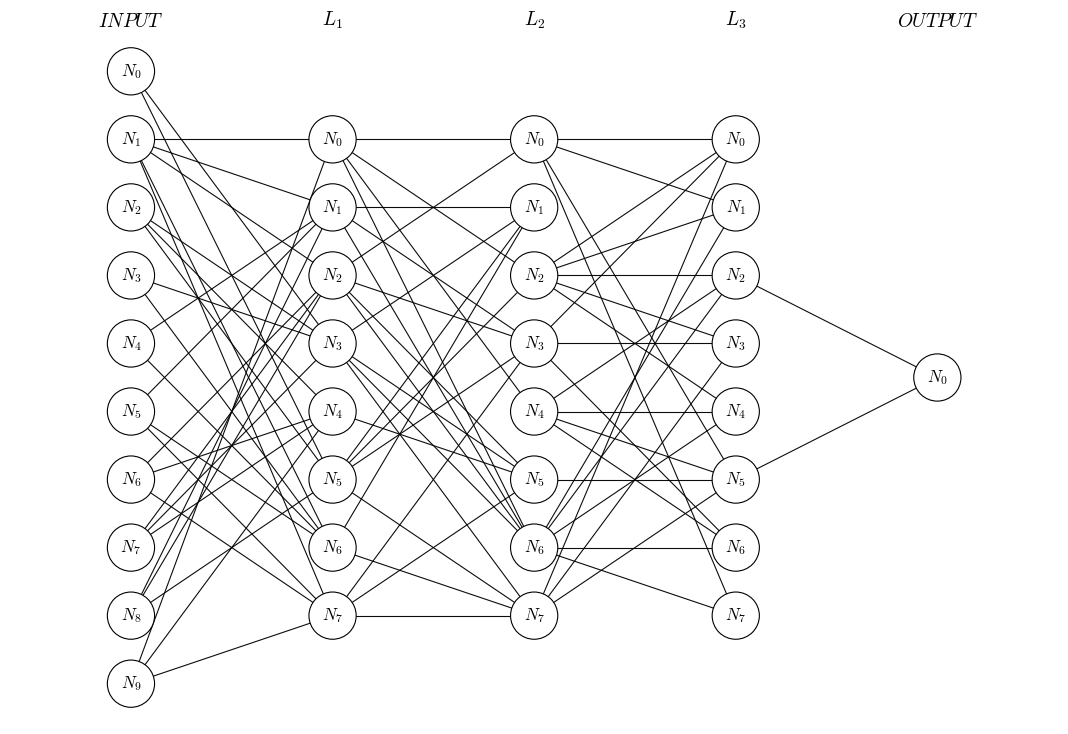

In [130]:
desc = describe_architecture_names_full(net)
plot_architecture_networkx(
    desc,
    x_gap=4,
    figsize=(20, 9),
    edge_width=0.8                  # call it line width maybe
)

In [131]:
def reduce_ripper_net(net) -> "DeepBinaryClassifier":
    """
    In-place reduction of all nodes (cuts backlinks).
    Does not change layer sizes; pruning is done separately.
    """
    for layer in net.layers:
        for node in layer:
            # only nodes that support reduction; harmless if others are present
            if hasattr(node, "reduce_expr"):
                node.reduce_expr()
    return net


# 1) Reduce all nodes
red_net = reduce_ripper_net(net)
#red_net = net

# 2) Prune unused nodes (keeps all current final outputs; reindexes X_cols)
red_net.prune(verbose=True)

Before pruning: [8, 8, 8, 1]
After pruning:  [8, 8, 4, 1]


In [132]:
pred_test_after = red_net.predict(X_test)
acc_after = accuracy_score(y_test, pred_test_after)
print(f"Accuracy (after pruning): {acc_after:.6f} (before: {acc_before:.6f})")

Accuracy (after pruning): 0.639024 (before: 0.848780)


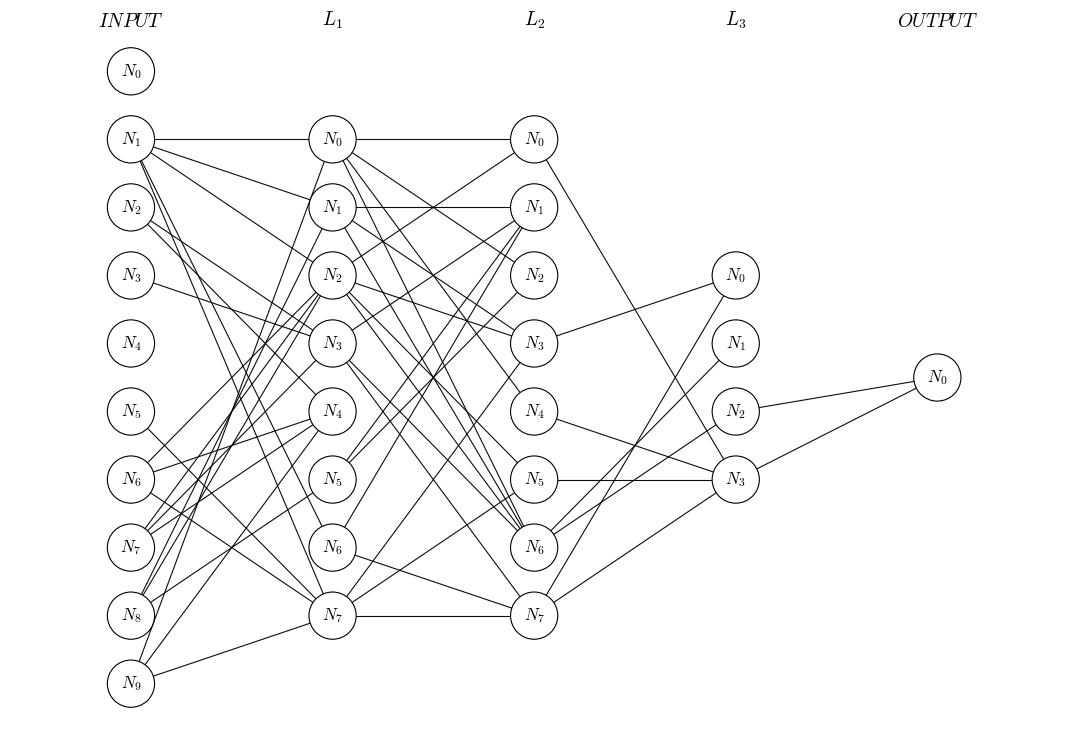

In [133]:
plot_architecture_networkx(
    desc_after,
    x_gap=4,
    figsize=(20, 9),
    edge_width=0.8                  # call it line width maybe
)